In [1]:
## Import modules

from Fourier_Neural_Operator import Fourier_Neural_Operator as FNO
from Fourier_Neural_Operator import SpectralConv2d_fast, SimpleBlock2d, Net2d 
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
## Plot function tests

# Simple ImageGrid plot for all 10 timesteps

def plot_images(data1):
    fig = plt.figure(figsize=(40., 40.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for i, ax in zip(range(0, 10),grid):
        # Iterating over the grid returns the Axes. #shape of arr is (nx, ny, time, channel)
        ax.imshow(np.array(data1.detach())[1,:,:,0,i])
        ax.set_title("Timestep: '{0}'".format(i))
        
# Plot function to compare prediction and ground truth

def plot_image_compare(pred, truth, step, fname = 'None'):
    f, axes = plt.subplots(3, 3, figsize=(10,8))
    
#     pred_im = stack_channels(pred) # Stack channels function
#     truth_im = stack_channels(truth) # Stack channels function
    
    pred = pred.detach()
    print(pred.shape, truth.shape)
    
    f.subplots_adjust(hspace = 0.5)
    
    for ax, i in zip(axes[0,:], range(1, len(truth[0,0,0,0,:]), step)):
        ax.imshow(truth[1,:,:,0,i])
        # i += 4
        ax.set_title('Ground Truth - Timestep {}'.format(i))
    for ax, i in zip(axes[1,:], range(1, len(pred[0,0,0,0,:]), step)):
        ax.imshow(pred[1,:,:,0,i])
        # i += 4
        ax.set_title('Prediction - Timestep {}'.format(i))
    for ax, i in zip(axes[2,:], range(1, len(pred[0,0,0,0,:]), step)):
        ax.imshow(pred[1,:,:,0,i] - truth[1,:,:,0,i])
        # i += 4
        ax.set_title('Difference - Timestep {}'.format(i))
        
    plt.tight_layout()
    plt.savefig(fname)

        
## Plot function to compare prediction and ground truth

# Function to add all channels in a single image
def stack_channels(images):
    c_a = np.array(images.detach())[:,:,:,0,:]
    c_b = np.array(images.detach())[:,:,:,1,:]
    c_c = 1 - c_a - c_b
    image = np.stack((c_a, c_b, c_c), axis = 3)
    return image

def stack_channels_np(images):
    c_a = np.array(images)[:,:,:,0,:]
    c_b = np.array(images)[:,:,:,1,:]
    c_c = 1 - c_a - c_b
    image = np.stack((c_a, c_b, c_c), axis = 3)
    return image

def plot_image_compare_sp(pred, truth, step, fname = 'None', title = 'None'):
    f, axes = plt.subplots(3, 3, figsize=(10,8))
    
    pred_im = stack_channels(pred) # Stack channels function
    truth_im = stack_channels(truth) # Stack channels function
    
    pred = pred_im[1,:,:,:,:]
    truth = truth_im[1,:,:,:,:]
    print(pred.shape, truth.shape)
    
    ls = torch.nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')
    
    f.subplots_adjust(hspace = 0.5)
    diff_arr = []
    
    for ax, i in zip(axes[0,:], range(1, len(truth[0,0,0,:]), step)):
        ax.imshow(truth[:,:,:,i])
        # i += 4
        ax.set_title('Ground Truth - Timestep {}'.format(i))
    for ax, i in zip(axes[1,:], range(1, len(pred[0,0,0,:]), step)):
        ax.imshow(pred[:,:,:,i])
        # i += 4
        ax.set_title('Prediction - Timestep {}'.format(i))
    for ax, i in zip(axes[2,:], range(1, len(pred[0,0,0,:]), step)):
        ax.imshow(pred[:,:,:,i] - truth[:,:,:,i])
        diff_arr.append(pred[:,:,:,i] - truth[:,:,:,i])
        mse = ls(torch.tensor(pred[:,:,:,i]), torch.tensor(truth[:,:,:,i]))
        # i += 4
        ax.set_title('Difference - Timestep {}, \n MSELoss: {}'.format(i, mse))
    
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(fname)
    return np.array(diff_arr)
    
    

In [3]:
## Upload model and dataset

import torch

model1 = 'model_ts0.25_20_20_re.pt'

checkpoint = torch.load(model1, map_location=torch.device('cpu'))
model = Net2d(12, 10) # (modes, width)
model.load_state_dict(checkpoint['model_state_dict'])

D = np.load('Data_dt0.25_ts60_lt.npy')
D.shape

(2, 64, 64, 2, 2000)

In [6]:
## Data organiaztion

sub = 1
S = 64
T_in = 20
T = 200
step = 1

ntest = 2

batch_size = 20

test_a = torch.tensor(D[-ntest:,::sub,::sub,::sub,:T_in])
test_u = torch.tensor(D[-ntest:,::sub,::sub,::sub,T_in:T+T_in])

gridx = torch.tensor(np.linspace(0, 64, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1).repeat([1, 1, S, 1])
gridx = gridx.reshape(1, S, S, 1, 1).repeat([1, 1, 1, 2, 1])
gridy = torch.tensor(np.linspace(0, 64, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1).repeat([1, S, 1, 1])
gridy = gridy.reshape(1, S, S, 1, 1).repeat([1, 1, 1, 2, 1])

test_a = torch.cat((test_a, gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1])), dim=-1)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [45]:
## Predictions
xx = []
yy = []
yh = []
for x, y in test_loader:
    xx.append(x)
    yy.append(y)

x = xx[0]

for t in range(0, 200, step):


    im = model(x.float())

    if t ==0:
        pred = im
    else:
        pred = torch.cat((pred, im), -1)
        # pred = im

    x = torch.cat((x[..., step:-2], im, gridx.repeat([ntest, 1, 1, 1, 1]), gridy.repeat([ntest, 1, 1, 1, 1])), dim=-1)

C:\Users\A Maruthi Indresh\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3, 200) (64, 64, 3, 200)


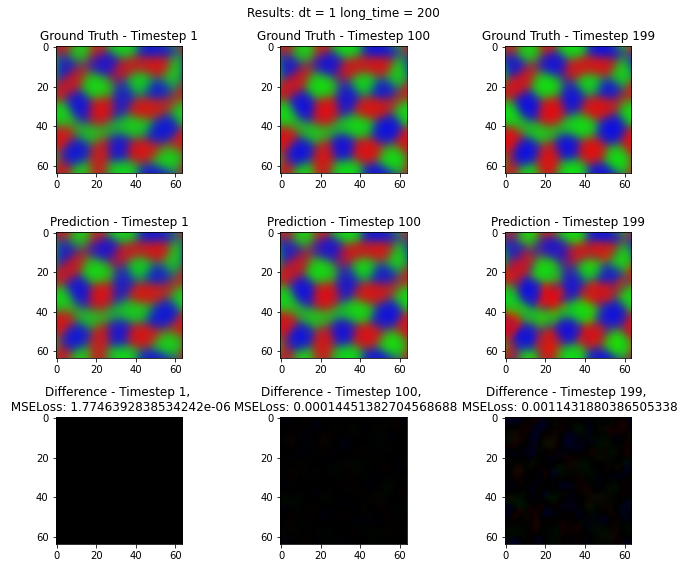

In [53]:
## Compare images predictions vd truth

diff_ar = plot_image_compare_sp(pred, yy[0], 99, fname = 'Data:dt=5.png', title = 'Results: dt = 1 long_time = 200')

In [46]:
print(pred.shape, yy[0].shape)

torch.Size([2, 64, 64, 2, 200]) torch.Size([2, 64, 64, 2, 200])


C:\Users\A Maruthi Indresh\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
<ipython-input-52-545a7eeca89c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ls = nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred[0,:,:,:,i]), torch.tensor(yy[0][0,:,:,:,i]))
<ipython-input-52-545a7eeca89c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(i, ls, torch.tensor(pred).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)


0 tensor(4.1627e-06, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
1 tensor(1.3666e-06, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
2 tensor(6.4839e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
3 tensor(5.8048e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
4 tensor(5.2764e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
5 tensor(6.2418e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
6 tensor(8.0387e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
7 tensor(7.5055e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
8 tensor(9.0158e-07, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
9 tensor(1.2054e-06, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
10 tensor(1.5487e-06, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([

100 tensor(9.4718e-05, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
101 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
102 tensor(9.9908e-05, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
103 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
104 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
105 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
106 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
107 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
108 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
109 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
110 tensor(0.0001, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])
11

199 tensor(0.0008, dtype=torch.float64) torch.Size([1, 3276800]) torch.Size([1, 3276800])


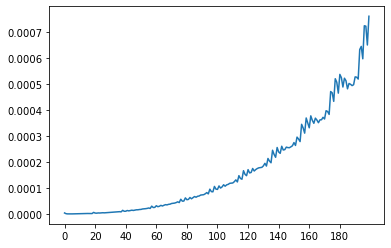

In [52]:
## Predictions till first 100 steps and graph

from torch import nn

loss = []
for i in range(0,200):
    #ls = nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred).view(1,-1), torch.tensor(yy[0]).view(1,-1))
    ls = nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred[0,:,:,:,i]), torch.tensor(yy[0][0,:,:,:,i]))
    print(i, ls, torch.tensor(pred).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)
    loss.append(ls)
    
plt.plot(np.array(loss))
plt.xticks(np.arange(0, 200, 20))
plt.savefig('LossCurve_dt5_w10.jpg')

In [55]:
pred3 = np.load('prediction_fno2_dt1.npy')[:,:,:,:,:1000]
print(pred3.shape)
D = np.load('Data_dt1_retrain_lt.npy')[:,:,:,:,:1000]
print(D.shape)
#D = D[:,:,:,:,:500]

(2, 64, 64, 2, 1000)
(2, 64, 64, 2, 1000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3, 1000) (64, 64, 3, 1500)


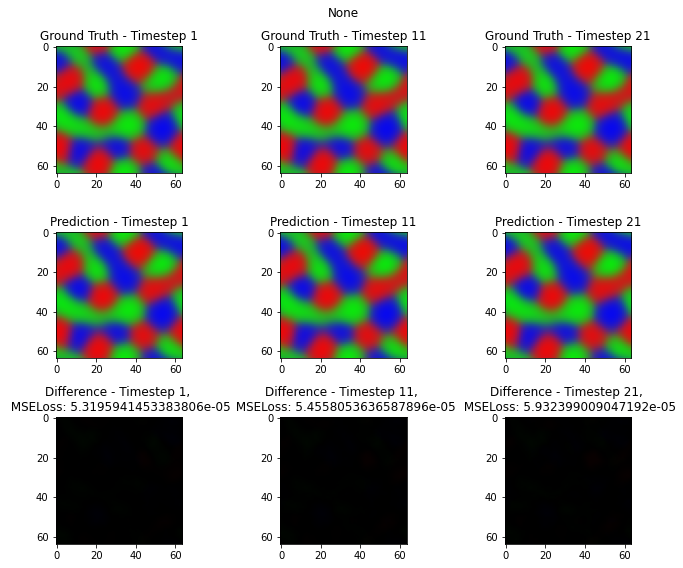

In [72]:
d1 = plot_image_compare_sp(torch.tensor(pred3), torch.tensor(D), 10)

<ipython-input-86-5ae177b5e0f1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(i, ls, torch.tensor(pred[1:]).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)


0 tensor(8.0435e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
1 tensor(8.0652e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
2 tensor(7.9968e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
3 tensor(8.0159e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
4 tensor(8.1011e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
5 tensor(8.2136e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
6 tensor(8.3526e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
7 tensor(8.4882e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
8 tensor(8.6074e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
9 tensor(8.6814e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
10 tensor(8.7371e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([

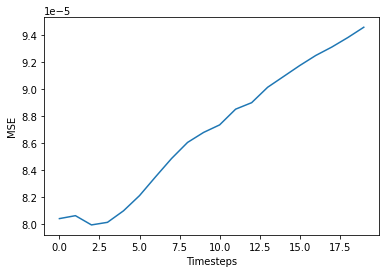

In [86]:
loss = []
for i in range(0,20):
    # ls = nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred[1,:]).view(1,-1), torch.tensor(yy[0][1,:]).view(1,-1))
    ls = torch.nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred3[:,:,:,:,i]), torch.tensor(D[:,:,:,:,i]))
    print(i, ls, torch.tensor(pred[1:]).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)
    loss.append(ls)

plt.ylabel('MSE')
plt.xlabel('Timesteps')
plt.plot(np.array(loss))

In [62]:
pred2 = np.load('prediction_fno3_dt1_w20_test.npy')
D = np.load('Data_dt1_retrain_lt.npy')
pred2.shape

(2, 64, 64, 2, 500)

C:\Users\A Maruthi Indresh\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3, 500) (64, 64, 3, 1010)


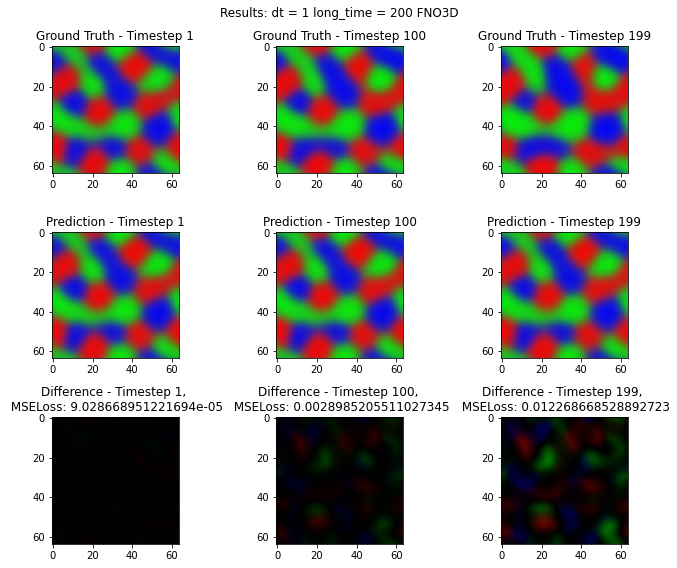

In [82]:
t2, p2, d2 = plot_image_compare_sp(torch.tensor(pred2), torch.tensor(D), 99, title = 'Results: dt = 1 long_time = 200 FNO3D')

<ipython-input-69-75d12606b564>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(i, ls, torch.tensor(pred[1:]).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)


0 tensor(0.0001, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
1 tensor(0.0001, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
2 tensor(8.6737e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
3 tensor(7.3710e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
4 tensor(6.2313e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
5 tensor(5.2526e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
6 tensor(4.4331e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
7 tensor(3.7706e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
8 tensor(3.2634e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
9 tensor(2.9095e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
10 tensor(2.7070e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 32768

97 tensor(0.0046, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
98 tensor(0.0047, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
99 tensor(0.0048, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
100 tensor(0.0049, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
101 tensor(0.0050, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
102 tensor(0.0051, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
103 tensor(0.0052, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
104 tensor(0.0053, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
105 tensor(0.0054, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
106 tensor(0.0055, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
107 tensor(0.0056, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
108 tensor(0.

203 tensor(0.0179, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
204 tensor(0.0181, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
205 tensor(0.0182, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
206 tensor(0.0184, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
207 tensor(0.0185, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
208 tensor(0.0186, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
209 tensor(0.0188, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
210 tensor(0.0189, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
211 tensor(0.0191, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
212 tensor(0.0192, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
213 tensor(0.0194, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
214 tensor

298 tensor(0.0331, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
299 tensor(0.0333, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
300 tensor(0.0335, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
301 tensor(0.0337, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
302 tensor(0.0338, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
303 tensor(0.0340, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
304 tensor(0.0342, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
305 tensor(0.0344, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
306 tensor(0.0346, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
307 tensor(0.0347, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
308 tensor(0.0349, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
309 tensor

395 tensor(0.0504, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
396 tensor(0.0505, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
397 tensor(0.0507, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
398 tensor(0.0509, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
399 tensor(0.0511, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
400 tensor(0.0513, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
401 tensor(0.0515, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
402 tensor(0.0516, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
403 tensor(0.0518, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
404 tensor(0.0520, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
405 tensor(0.0522, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
406 tensor

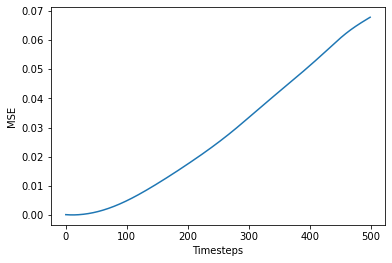

In [69]:
loss = []
for i in range(0,500):
    # ls = nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred[1,:]).view(1,-1), torch.tensor(yy[0][1,:]).view(1,-1))
    ls = torch.nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred2[:,:,:,:,i]), torch.tensor(D[:,:,:,:,i]))
    print(i, ls, torch.tensor(pred[1:]).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)
    loss.append(ls)

plt.ylabel('MSE')
plt.xlabel('Timesteps')
plt.plot(np.array(loss))

In [ ]:
plt.imshow(d1[2]-d2[2])
print(d1[2] - d2[2])
print(np.linalg.norm(d1[2] - d2[2]))

In [75]:
pred_old = np.load('prediction_fno3_10_20_ep100_test.npy')
D = np.load('Data_dt1_retrain_lt.npy')
D = D[:,:,:,:,:1010]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3, 500) (64, 64, 3, 1010)


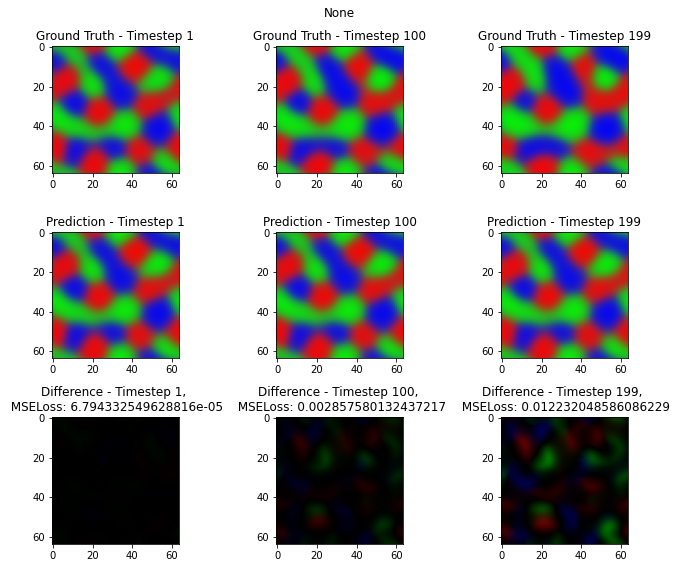

In [76]:
d = plot_image_compare_sp(torch.tensor(pred_old), torch.tensor(D), 99)

C:\Users\A Maruthi Indresh\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
<ipython-input-81-3c8fde0a23db>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(i, ls, torch.tensor(pred[1:]).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)


0 tensor(0.0001, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
1 tensor(9.8180e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
2 tensor(8.1259e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
3 tensor(6.6150e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
4 tensor(5.2823e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
5 tensor(4.1260e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
6 tensor(3.1437e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
7 tensor(2.3330e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
8 tensor(1.6908e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
9 tensor(1.2143e-05, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
10 tensor(9.0086e-06, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3

93 tensor(0.0041, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
94 tensor(0.0042, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
95 tensor(0.0043, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
96 tensor(0.0044, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
97 tensor(0.0045, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
98 tensor(0.0046, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
99 tensor(0.0047, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
100 tensor(0.0048, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
101 tensor(0.0049, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
102 tensor(0.0050, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
103 tensor(0.0051, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
104 tensor(0.0052

199 tensor(0.0173, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
200 tensor(0.0174, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
201 tensor(0.0175, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
202 tensor(0.0177, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
203 tensor(0.0178, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
204 tensor(0.0180, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
205 tensor(0.0181, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
206 tensor(0.0182, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
207 tensor(0.0184, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
208 tensor(0.0185, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
209 tensor(0.0187, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
210 tensor

293 tensor(0.0321, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
294 tensor(0.0323, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
295 tensor(0.0325, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
296 tensor(0.0327, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
297 tensor(0.0328, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
298 tensor(0.0330, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
299 tensor(0.0332, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
300 tensor(0.0334, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
301 tensor(0.0336, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
302 tensor(0.0337, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
303 tensor(0.0339, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
304 tensor

386 tensor(0.0485, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
387 tensor(0.0487, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
388 tensor(0.0488, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
389 tensor(0.0490, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
390 tensor(0.0492, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
391 tensor(0.0494, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
392 tensor(0.0496, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
393 tensor(0.0497, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
394 tensor(0.0499, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
395 tensor(0.0501, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
396 tensor(0.0503, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
397 tensor

493 tensor(0.0670, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
494 tensor(0.0671, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
495 tensor(0.0672, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
496 tensor(0.0674, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
497 tensor(0.0675, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
498 tensor(0.0677, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])
499 tensor(0.0678, dtype=torch.float64) torch.Size([1, 1638400]) torch.Size([1, 3276800])


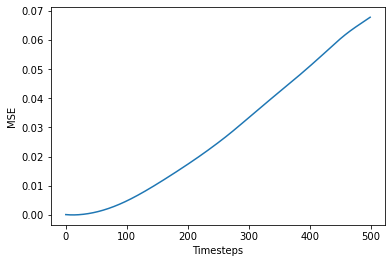

In [81]:
loss = []
for i in range(0,500):
    # ls = nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred[1,:]).view(1,-1), torch.tensor(yy[0][1,:]).view(1,-1))
    ls = torch.nn.MSELoss(size_average = True, reduce = True, reduction = 'mean')(torch.tensor(pred_old[:,:,:,:,i]), torch.tensor(D[:,:,:,:,i]))
    print(i, ls, torch.tensor(pred[1:]).view(1,-1).shape, torch.tensor(yy[0]).view(1,-1).shape)
    loss.append(ls)

plt.ylabel('MSE')
plt.xlabel('Timesteps')
plt.plot(np.array(loss))